### Datasets and DataLoaders

In [1]:
!pip install segmentation_models_pytorch

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 106.7/106.7 kB 3.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 6.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 13.5 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_6

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import os
def get_direct_subfolders(directory):
    subfolders = [f.path for f in os.scandir(directory) if f.is_dir()]
    return subfolders

def get_direct_subfiles(directory):
    subfiles = [f.path for f in os.scandir(directory) if f.is_file()]
    return subfiles

In [5]:
import os, torch, random, numpy as np, albumentations as A, nibabel as nib
from matplotlib import pyplot as plt; from glob import glob
from torch.utils.data import random_split, Dataset, DataLoader
from albumentations.pytorch import ToTensorV2
import gc


class CustomSegmentationDataset(Dataset):

    def __init__(self, data_path, transformations = None):
        self.ims, self.gts = self.get_slices(data_path)
        self.transformations = transformations
        self.n_cls = 2

        assert len(self.ims) == len(self.gts)

    def __len__(self): return len(self.ims)

    def __getitem__(self, idx):

        im, gt = self.ims[idx], self.gts[idx]
        if self.transformations: im, gt = self.apply_transformations(im, gt)

        # For visualization purposes
        im = self.preprocess_im(im)
        # For the cases when label equals to 2; to avoid CE Loss error
        gt[gt > 1] = 1

        return im.float(), gt.unsqueeze(0).long()

    def preprocess_im(self, im):

        max_val = torch.max(im)
        im[im < 0] = 0

        return im / max_val

    def get_slices(self, data_path):
      ims, gts = [], []
      subfolders = get_direct_subfolders(data_path)
      for subfolder in subfolders:
          print("Petient folder: ", subfolder)
          subfiles = get_direct_subfiles(subfolder)
          # paths:
          seg_file = os.path.join( subfolder, os.path.basename(subfolder)+"-seg.nii.gz")
          t1c_file = os.path.join( subfolder, os.path.basename(subfolder)+"-t1c.nii.gz")
          t1n_file = os.path.join( subfolder, os.path.basename(subfolder)+"-t1n.nii.gz")
          t2f_file = os.path.join( subfolder, os.path.basename(subfolder)+"-t2f.nii.gz")
          t2w_file = os.path.join( subfolder, os.path.basename(subfolder)+"-t2w.nii.gz")

          nifti_img_seg = nib.load(seg_file)
          nifti_img_t1c = nib.load(t1c_file)
          nifti_img_t1n = nib.load(t1n_file)
          nifti_img_t2f = nib.load(t2f_file)
          nifti_img_t2w = nib.load(t2w_file)

          # Get the image data as a NumPy array
          img_data_seg = nifti_img_seg.get_fdata()
          img_data_t1c = nifti_img_t1c.get_fdata()
          img_data_t1n = nifti_img_t1n.get_fdata()
          img_data_t2f = nifti_img_t2f.get_fdata()
          img_data_t2w = nifti_img_t2w.get_fdata()

          # Find the index of the frame with the most pixels above zero
          nonzero_counts = [np.count_nonzero(slice_img) for slice_img in img_data_seg.transpose(2, 0, 1)]
          max_index = np.argmax(nonzero_counts)
          # Extract the frame with the most pixels above zero
          selected_frame_seg = img_data_seg[:, :, max_index]
          selected_frame_t1c = img_data_t1c[:, :, max_index]
          selected_frame_t1n = img_data_t1n[:, :, max_index]
          selected_frame_t2f = img_data_t2f[:, :, max_index]
          selected_frame_t2w = img_data_t2w[:, :, max_index]

          del nifti_img_seg
          del nifti_img_t1c
          del nifti_img_t1n
          del nifti_img_t2f
          del nifti_img_t2w

          del img_data_seg
          del img_data_t1c
          del img_data_t1n
          del img_data_t2f
          del img_data_t2w

          gts.append(selected_frame_seg)
          ims.append(np.array((selected_frame_t1c, selected_frame_t1n,
                      selected_frame_t2f, selected_frame_t2w)))
          gc.collect()

          if len(ims)==400:
            break
      return ims, gts

    def read_nii(self, im, gt): return nib.load(im).get_fdata().transpose(2, 1, 0), nib.load(gt).get_fdata().transpose(2, 1, 0)

    def apply_transformations(self, im, gt): transformed = self.transformations(image = im, mask = gt); return transformed["image"], transformed["mask"]

def get_dls(path, transformations, bs, split = [0.9, 0.05, 0.05], ns = 4):

    assert sum(split) == 1., "Sum of the split must be exactly 1"

    ds = CustomSegmentationDataset(data_path = path, transformations = transformations)
    n_cls = ds.n_cls

    tr_len = int(len(ds) * split[0])
    val_len = int(len(ds) * split[1])
    test_len = int(len(ds) - (tr_len + val_len))

    # Data split
    tr_ds, val_ds, test_ds = torch.utils.data.random_split(ds, [tr_len, val_len, test_len])

    print(f"\nThere are {len(tr_ds)} number of images in the train set")
    print(f"There are {len(val_ds)} number of images in the validation set")
    print(f"There are {len(test_ds)} number of images in the test set\n")

    # Get dataloaders
    tr_dl  = DataLoader(dataset = tr_ds, batch_size = bs, shuffle = True, num_workers = ns)
    val_dl = DataLoader(dataset = val_ds, batch_size = bs, shuffle = False, num_workers = ns)
    test_dl = DataLoader(dataset = test_ds, batch_size = 1, shuffle = False, num_workers = ns)

    return tr_dl, val_dl, test_dl, n_cls

data_path = r'/content/drive/MyDrive/Brats21 Data/Dataset/training/ASNR-MICCAI-BraTS2023-GLI-Challenge-TrainingData'

mean, std, im_h, im_w = [0.485, 0.456, 0.406], [0.229, 0.224, 0.225], 256, 256
trans = A.Compose( [A.Resize(im_h, im_w), ToTensorV2(transpose_mask = True) ],
                  is_check_shapes=False)
tr_dl, val_dl, test_dl, n_cls = get_dls(path = data_path, transformations = trans, bs = 16)

Petient folder:  /content/drive/MyDrive/Brats21 Data/Dataset/training/ASNR-MICCAI-BraTS2023-GLI-Challenge-TrainingData/BraTS-GLI-01291-000
Petient folder:  /content/drive/MyDrive/Brats21 Data/Dataset/training/ASNR-MICCAI-BraTS2023-GLI-Challenge-TrainingData/BraTS-GLI-01292-000
Petient folder:  /content/drive/MyDrive/Brats21 Data/Dataset/training/ASNR-MICCAI-BraTS2023-GLI-Challenge-TrainingData/BraTS-GLI-01281-000
Petient folder:  /content/drive/MyDrive/Brats21 Data/Dataset/training/ASNR-MICCAI-BraTS2023-GLI-Challenge-TrainingData/BraTS-GLI-01282-000
Petient folder:  /content/drive/MyDrive/Brats21 Data/Dataset/training/ASNR-MICCAI-BraTS2023-GLI-Challenge-TrainingData/BraTS-GLI-01283-000
Petient folder:  /content/drive/MyDrive/Brats21 Data/Dataset/training/ASNR-MICCAI-BraTS2023-GLI-Challenge-TrainingData/BraTS-GLI-01284-000
Petient folder:  /content/drive/MyDrive/Brats21 Data/Dataset/training/ASNR-MICCAI-BraTS2023-GLI-Challenge-TrainingData/BraTS-GLI-01285-000
Petient folder:  /content/d

### Train Setup and Evaluation Metrics

In [6]:
import segmentation_models_pytorch as Unet, time
from tqdm import tqdm
from torch.nn import functional as F

model = Unet.DeepLabV3Plus(classes = n_cls, in_channels = 240)
loss_fn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params = model.parameters(), lr = 3e-4)

class Metrics():

    def __init__(self, pred, gt, loss_fn, eps = 1e-10, n_cls = 2):

        self.pred, self.gt = torch.argmax(pred, dim = 1) > 0, gt # (batch, width, height)
        self.loss_fn, self.eps, self.n_cls, self.pred_, self.device = loss_fn, eps, n_cls, pred, device

    def to_contiguous(self, inp): return inp.contiguous().view(-1)

    def PA(self):

        with torch.no_grad():
            match = torch.eq(self.pred, self.gt).int()

        return float(match.sum()) / float(match.numel())

    def mIoU(self):

        with torch.no_grad():

            pred, gt = self.to_contiguous(self.pred), self.to_contiguous(self.gt)

            iou_per_class = []

            for c in range(self.n_cls):

                match_pred = pred == c
                match_gt   = gt == c

                if match_gt.long().sum().item() == 0: iou_per_class.append(np.nan)

                else:

                    intersect = torch.logical_and(match_pred, match_gt).sum().float().item()
                    union = torch.logical_or(match_pred, match_gt).sum().float().item()

                    iou = (intersect + self.eps) / (union + self.eps)
                    iou_per_class.append(iou)

            return np.nanmean(iou_per_class)

    def loss(self): return self.loss_fn(self.pred_, self.gt.squeeze(1))

def tic_toc(start_time = None): return time.time() if start_time == None else time.time() - start_time

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.cache/torch/hub/checkpoints/resnet34-333f7ec4.pth
100%|██████████| 83.3M/83.3M [00:00<00:00, 212MB/s]


### AI Model Train and Evaluation

In [7]:
save_prefix = "brats"
def train(model, tr_dl, val_dl, loss_fn, opt, device, epochs, save_prefix, threshold = 0.005, save_path = "saved_models"):

    tr_loss, tr_pa, tr_iou = [], [], []
    val_loss, val_pa, val_iou = [], [], []
    tr_len, val_len = len(tr_dl), len(val_dl)
    best_loss, decrease, not_improve, early_stop_threshold = np.inf, 1, 0, 5
    os.makedirs(save_path, exist_ok = True)

    model.to(device)
    train_start = tic_toc()
    print("Start training process...")

    for epoch in range(1, epochs + 1):
        tic = tic_toc()
        tr_loss_, tr_iou_, tr_pa_ = 0, 0, 0

        model.train()
        print(f"Epoch {epoch} train process is started...")
        for idx, batch in enumerate(tqdm(tr_dl)):
            ims, gts = batch
            ims, gts = ims.to(device), gts.to(device).long()

            preds = model(ims)

            met = Metrics(preds, gts, loss_fn, n_cls = n_cls)
            loss_ = met.loss().requires_grad_()

            tr_iou_ += met.mIoU()
            tr_pa_ += met.PA()
            tr_loss_ += loss_.item()

            loss_.backward()
            opt.step()
            opt.zero_grad()

        print(f"Epoch {epoch} validation process is started...")
        model.eval()
        val_loss_, val_iou_, val_pa_ = 0, 0, 0

        with torch.no_grad():
            for idx, batch in enumerate(tqdm(val_dl)):

                ims, gts = batch
                ims, gts = ims.to(device), gts.to(device)

                preds = model(ims)

                met = Metrics(preds, gts, loss_fn, n_cls = n_cls)

                val_loss_ += met.loss().item()
                val_iou_ += met.mIoU()
                val_pa_ += met.PA()

        print(f"Epoch {epoch} train process is completed.")

        tr_loss_ /= tr_len
        tr_iou_ /= tr_len
        tr_pa_ /= tr_len

        val_loss_ /= val_len
        val_iou_ /=  val_len
        val_pa_ /=   val_len

        print("\n~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~")
        print(f"\nEpoch {epoch} train process results: \n")
        print(f"Train Time         -> {tic_toc(tic):.3f} secs")
        print(f"Train Loss         -> {tr_loss_:.3f}")
        print(f"Train PA           -> {tr_pa_:.3f}")
        print(f"Train IoU          -> {tr_iou_:.3f}")
        print(f"Validation Loss    -> {val_loss_:.3f}")
        print(f"Validation PA      -> {val_pa_:.3f}")
        print(f"Validation IoU     -> {val_iou_:.3f}\n")

        tr_loss.append(tr_loss_)
        tr_iou.append(tr_iou_)
        tr_pa.append(tr_pa_)

        val_loss.append(val_loss_)
        val_iou.append(val_iou_)
        val_pa.append(val_pa_)

        if best_loss > (val_loss_ + threshold):
            print(f"Loss decreased from {best_loss:.3f} to {val_loss_:.3f}!")
            best_loss = val_loss_
            decrease += 1
            if decrease % 2 == 0:
                print("Saving the model with the best loss value...")
                torch.save(model, f"{save_path}/{save_prefix}_best_model.pt")

        else:

            not_improve += 1
            best_loss = val_loss_
            print(f"Loss did not decrease for {not_improve} epoch(s)!")
            if not_improve == early_stop_threshold:
                print(f"Stopping training process becuase loss value did not decrease for {early_stop_threshold} epochs!")
                break
        print("~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~\n")

    print(f"Train process is completed in {(tic_toc(train_start)) / 60:.3f} minutes.")

    return {"tr_loss": tr_loss, "tr_iou": tr_iou, "tr_pa": tr_pa,
            "val_loss": val_loss, "val_iou": val_iou, "val_pa" : val_pa}

device = "cuda" if torch.cuda.is_available() else "cpu"

history = train(model = model, tr_dl = tr_dl, val_dl = val_dl,
                 loss_fn = loss_fn, opt = optimizer, device = device,
                 epochs = 50, save_prefix = save_prefix)

Start training process...
Epoch 1 train process is started...


  0%|          | 0/23 [00:00<?, ?it/s]/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
100%|██████████| 23/23 [01:06<00:00,  2.91s/it]


Epoch 1 validation process is started...


100%|██████████| 2/2 [00:11<00:00,  5.54s/it]


Epoch 1 train process is completed.

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Epoch 1 train process results: 

Train Time         -> 77.909 secs
Train Loss         -> 0.426
Train PA           -> 0.862
Train IoU          -> 0.479
Validation Loss    -> 0.485
Validation PA      -> 0.917
Validation IoU     -> 0.509

Loss decreased from inf to 0.485!
Saving the model with the best loss value...
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Epoch 2 train process is started...


100%|██████████| 23/23 [01:03<00:00,  2.77s/it]


Epoch 2 validation process is started...


100%|██████████| 2/2 [00:11<00:00,  5.55s/it]


Epoch 2 train process is completed.

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Epoch 2 train process results: 

Train Time         -> 74.842 secs
Train Loss         -> 0.159
Train PA           -> 0.953
Train IoU          -> 0.523
Validation Loss    -> 0.143
Validation PA      -> 0.951
Validation IoU     -> 0.588

Loss decreased from 0.485 to 0.143!
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Epoch 3 train process is started...


100%|██████████| 23/23 [01:04<00:00,  2.81s/it]


Epoch 3 validation process is started...


100%|██████████| 2/2 [00:11<00:00,  5.58s/it]


Epoch 3 train process is completed.

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Epoch 3 train process results: 

Train Time         -> 75.748 secs
Train Loss         -> 0.107
Train PA           -> 0.943
Train IoU          -> 0.646
Validation Loss    -> 0.090
Validation PA      -> 0.947
Validation IoU     -> 0.696

Loss decreased from 0.143 to 0.090!
Saving the model with the best loss value...
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Epoch 4 train process is started...


100%|██████████| 23/23 [01:04<00:00,  2.81s/it]


Epoch 4 validation process is started...


100%|██████████| 2/2 [00:10<00:00,  5.50s/it]


Epoch 4 train process is completed.

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Epoch 4 train process results: 

Train Time         -> 75.694 secs
Train Loss         -> 0.090
Train PA           -> 0.940
Train IoU          -> 0.697
Validation Loss    -> 0.094
Validation PA      -> 0.937
Validation IoU     -> 0.680

Loss did not decrease for 1 epoch(s)!
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Epoch 5 train process is started...


100%|██████████| 23/23 [01:04<00:00,  2.78s/it]


Epoch 5 validation process is started...


100%|██████████| 2/2 [00:10<00:00,  5.50s/it]


Epoch 5 train process is completed.

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Epoch 5 train process results: 

Train Time         -> 75.044 secs
Train Loss         -> 0.081
Train PA           -> 0.939
Train IoU          -> 0.712
Validation Loss    -> 0.071
Validation PA      -> 0.946
Validation IoU     -> 0.736

Loss decreased from 0.094 to 0.071!
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Epoch 6 train process is started...


100%|██████████| 23/23 [01:04<00:00,  2.79s/it]


Epoch 6 validation process is started...


100%|██████████| 2/2 [00:11<00:00,  5.58s/it]


Epoch 6 train process is completed.

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Epoch 6 train process results: 

Train Time         -> 75.286 secs
Train Loss         -> 0.070
Train PA           -> 0.937
Train IoU          -> 0.755
Validation Loss    -> 0.065
Validation PA      -> 0.949
Validation IoU     -> 0.752

Loss decreased from 0.071 to 0.065!
Saving the model with the best loss value...
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Epoch 7 train process is started...


100%|██████████| 23/23 [01:03<00:00,  2.78s/it]


Epoch 7 validation process is started...


100%|██████████| 2/2 [00:11<00:00,  5.51s/it]


Epoch 7 train process is completed.

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Epoch 7 train process results: 

Train Time         -> 74.885 secs
Train Loss         -> 0.067
Train PA           -> 0.937
Train IoU          -> 0.753
Validation Loss    -> 0.062
Validation PA      -> 0.951
Validation IoU     -> 0.739

Loss did not decrease for 2 epoch(s)!
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Epoch 8 train process is started...


100%|██████████| 23/23 [01:04<00:00,  2.81s/it]


Epoch 8 validation process is started...


100%|██████████| 2/2 [00:11<00:00,  5.50s/it]


Epoch 8 train process is completed.

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Epoch 8 train process results: 

Train Time         -> 75.557 secs
Train Loss         -> 0.061
Train PA           -> 0.937
Train IoU          -> 0.770
Validation Loss    -> 0.067
Validation PA      -> 0.941
Validation IoU     -> 0.746

Loss did not decrease for 3 epoch(s)!
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Epoch 9 train process is started...


100%|██████████| 23/23 [01:04<00:00,  2.79s/it]


Epoch 9 validation process is started...


100%|██████████| 2/2 [00:11<00:00,  5.50s/it]


Epoch 9 train process is completed.

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Epoch 9 train process results: 

Train Time         -> 75.196 secs
Train Loss         -> 0.058
Train PA           -> 0.935
Train IoU          -> 0.779
Validation Loss    -> 0.071
Validation PA      -> 0.943
Validation IoU     -> 0.719

Loss did not decrease for 4 epoch(s)!
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Epoch 10 train process is started...


100%|██████████| 23/23 [01:04<00:00,  2.80s/it]


Epoch 10 validation process is started...


100%|██████████| 2/2 [00:11<00:00,  5.55s/it]


Epoch 10 train process is completed.

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Epoch 10 train process results: 

Train Time         -> 75.459 secs
Train Loss         -> 0.056
Train PA           -> 0.935
Train IoU          -> 0.784
Validation Loss    -> 0.052
Validation PA      -> 0.946
Validation IoU     -> 0.775

Loss decreased from 0.071 to 0.052!
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Epoch 11 train process is started...


100%|██████████| 23/23 [01:04<00:00,  2.79s/it]


Epoch 11 validation process is started...


100%|██████████| 2/2 [00:11<00:00,  5.59s/it]


Epoch 11 train process is completed.

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Epoch 11 train process results: 

Train Time         -> 75.323 secs
Train Loss         -> 0.051
Train PA           -> 0.936
Train IoU          -> 0.800
Validation Loss    -> 0.059
Validation PA      -> 0.946
Validation IoU     -> 0.756

Loss did not decrease for 5 epoch(s)!
Stopping training process becuase loss value did not decrease for 5 epochs!
Train process is completed in 13.861 minutes.


### Learning Curves

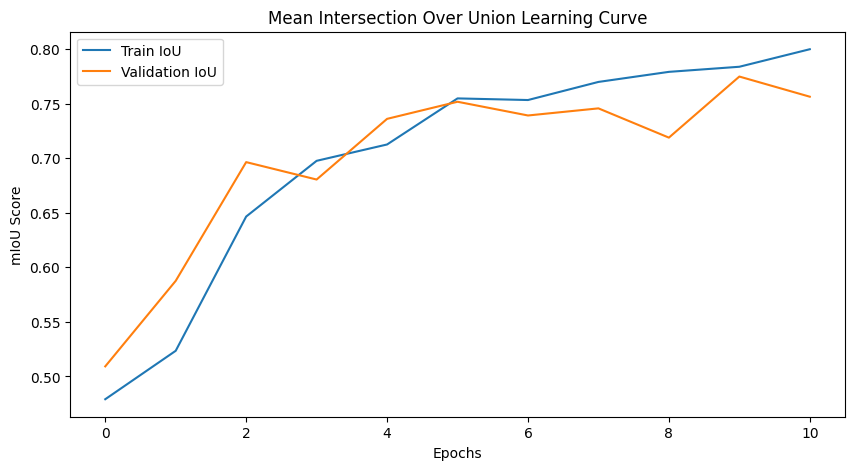

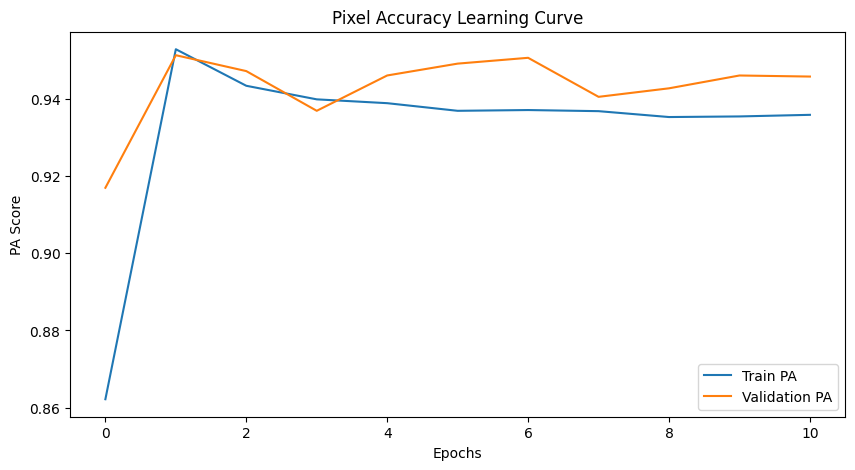

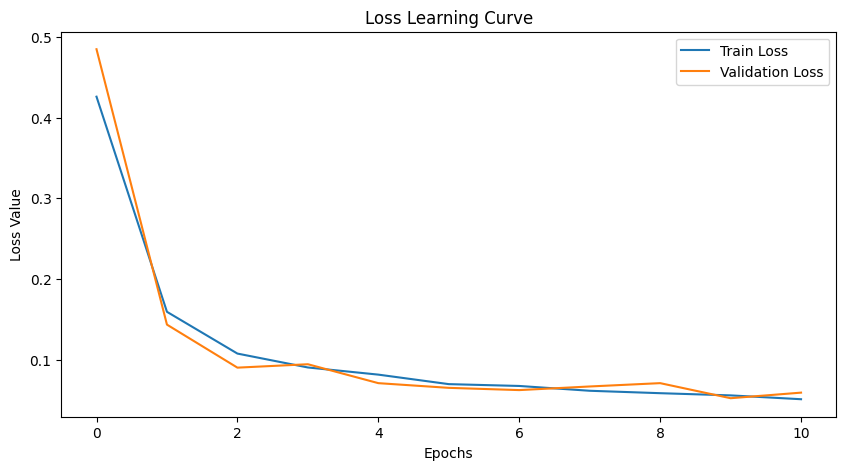

In [8]:
class Plot():

    def __init__(self, res):

        self.res = res

        self.visualize(metric1 = "tr_iou", metric2 = "val_iou", label1 = "Train IoU",
                  label2 = "Validation IoU", title = "Mean Intersection Over Union Learning Curve", ylabel = "mIoU Score")

        self.visualize(metric1 = "tr_pa", metric2 = "val_pa", label1 = "Train PA",
                  label2 = "Validation PA", title = "Pixel Accuracy Learning Curve", ylabel = "PA Score")

        self.visualize(metric1 = "tr_loss", metric2 = "val_loss", label1 = "Train Loss",
                  label2 = "Validation Loss", title = "Loss Learning Curve", ylabel = "Loss Value")


    def plot(self, metric, label): plt.plot(self.res[metric], label = label)

    def decorate(self, ylabel, title): plt.title(title); plt.xlabel("Epochs"); plt.ylabel(ylabel); plt.legend(); plt.show()

    def visualize(self, metric1, metric2, label1, label2, title, ylabel):

        plt.figure(figsize=(10, 5))
        self.plot(metric1, label1); self.plot(metric2, label2)
        self.decorate(ylabel, title)

Plot(history)

### Inference and Model Performance Analysis

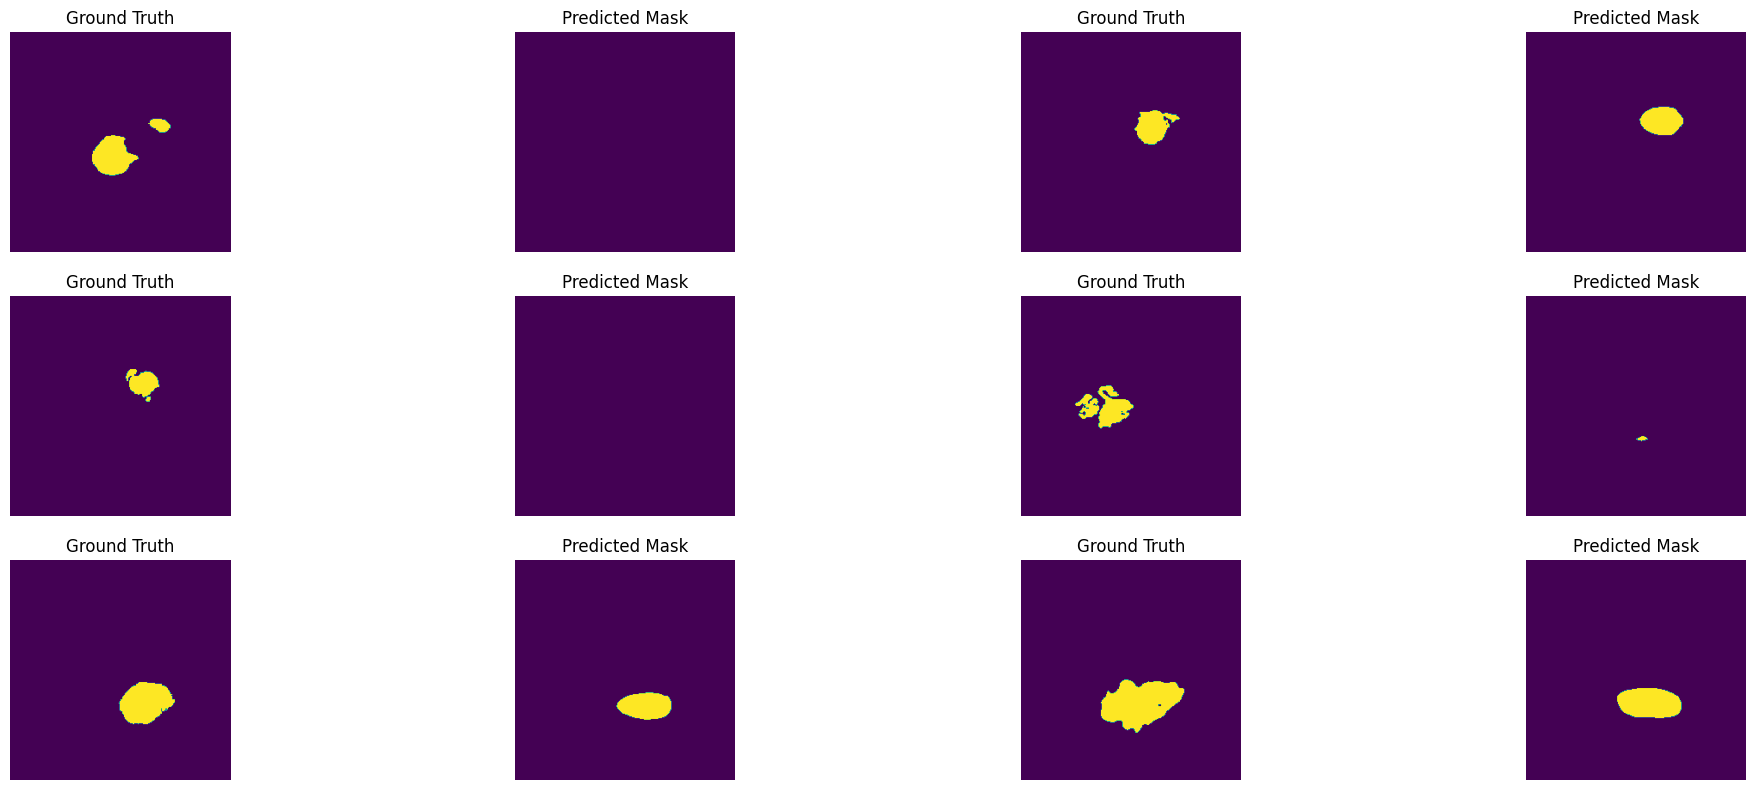

In [18]:
def plot(rows, cols, count, im, gt = None, title = "Original Image"):

    plt.subplot(rows, cols, count)
    plt.imshow(im.squeeze(0).float()) if gt else plt.imshow((im * 255).cpu().permute(1, 2, 0).numpy().astype("uint8") * 255)
    plt.axis("off"); plt.title(title)

    return count + 1
def inference(dl, model, device, n_ims = 24):

    cols = n_ims // 4; rows = n_ims // cols

    count = 1
    ims, gts, preds = [], [], []
    for idx, data in enumerate(dl):
        im, gt = data

        # Get predicted mask
        with torch.no_grad(): pred = torch.argmax(model(im.to(device)), dim = 1)
        ims.append(im); gts.append(gt); preds.append(pred)

    plt.figure(figsize = (25, 20))
    for idx, (im, gt, pred) in enumerate(zip(ims, gts, preds)):
        if idx == cols: break


        #  First plot
        count = plot(cols, rows, count, im = gt.squeeze(0), gt = True, title = "Ground Truth")

        #  Second plot
        count = plot(cols, rows, count, im = pred, title = "Predicted Mask")

model = torch.load(f"saved_models/{save_prefix}_best_model.pt")
inference(test_dl, model = model, device = device)